In [1]:
from google.colab import drive

drive.mount('/content/gdrive') # experiments

!rm -rf /content/dataset
!mkdir -p /content/dataset

Mounted at /content/gdrive


## Sync datasets from Drive

In [2]:
!rm -rf /content/full_hust_dataset_combined
!mkdir /content/full_hust_dataset_combined

import glob, shutil
for data_file in glob.glob(f'/content/gdrive/My Drive/full_hust_dataset_combined/*test*.zip'):

  file_name = data_file.split('/')[-1].replace('test', 'train')
  shutil.copyfile(data_file, f'/content/full_hust_dataset_combined/{file_name}')

In [3]:
%%capture
for zip_file in glob.glob('/content/*/*train*.zip'):
  !unzip $zip_file

## Update modules

In [4]:
import shutil

def send_modules():
  !rm -rf '/content/gdrive/My Drive/EyeTracking/modules'
  shutil.copytree('/content/modules', '/content/gdrive/My Drive/EyeTracking/modules')
  print(f'modules send to : /content/gdrive/My Drive/EyeTracking/modules')
def recieve_modules():
  !rm -rf '/content/modules'
  shutil.copytree('/content/gdrive/My Drive/EyeTracking/modules', '/content/modules')
  print('modules recieved to : /content/modules')

In [5]:
#recieve_modules()
#send_modules()

modules recieved to : /content/modules


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from modules.get_features import get_features_for_sample
from modules.data_utils import get_dataset_filedirvslabel
from modules.feature_functions import feature_func_eyeimages, feature_func_frp
from modules.detectors import get_detectors
from modules.eyeimage_features import eyeimages2lbp


blink_data_dir = '/content/blink'
unblink_data_dir= '/content/unblink'

## Create dataset

In [8]:
import numpy as np
def create_feature_dataset(blink_data_dir, unblink_data_dir, feature_func= feature_func_frp, n_frames_per_vid=10, type_= 'train', train_ratio=0.8):
  dataset =[]

  np.random.seed(10)
  dataset_filedirvslabel_all = sorted(list(get_dataset_filedirvslabel(blink_data_dir))+ list(get_dataset_filedirvslabel(unblink_data_dir)))
  np.random.shuffle(dataset_filedirvslabel_all)

  train_len= int(len(dataset_filedirvslabel_all)*train_ratio)

  if type_=='train':dataset_filedirvslabel= dataset_filedirvslabel_all[:train_len]
  else:dataset_filedirvslabel= dataset_filedirvslabel_all[train_len:]

  #for dataset_filedirvslabel_sample in dataset_filedirvslabel:
  #  sample_id = int(dataset_filedirvslabel_sample[0][0].split('/')[-3])

  for sample_id in range(len(dataset_filedirvslabel)):
    print(f'sample_id : {sample_id}/ {len(dataset_filedirvslabel)}')
    detector, landmark_detector = get_detectors()
    features, label = get_features_for_sample(dataset_filedirvslabel, sample_id, feature_func, detector, landmark_detector, check_errors=False)
    try:
      features.shape #to check features is not None

      if len(features[0])==n_frames_per_vid:
        dataset.append([features,label])
      else:print('length features are not 10 !!!')

    except:
      if features==None:print(f'features not extracted : sample_id : {sample_id}')
      else:print('error not handled')
  return dataset

## Train

In [9]:
import torch
from torch import nn
from modules.nn_models import simple_lstm
from modules.train import train
from modules.data import get_dataset

device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = simple_lstm(lstm_input_feature_size= 1, bidirectional=False).to(device)
criterion= nn.BCELoss().to(device)
opt= torch.optim.Adam(model.parameters(), lr= 0.001)

dataset_train = create_feature_dataset(blink_data_dir, unblink_data_dir, feature_func= feature_func_eyeimages, n_frames_per_vid=10, type_= 'train')
dataset_test = create_feature_dataset(blink_data_dir, unblink_data_dir, feature_func= feature_func_eyeimages, n_frames_per_vid=10, type_= 'test')

sample_id : 0/ 180
no faces detected : /content/blink/63/10/00012.bmp
features not extracted : sample_id : 0
sample_id : 1/ 180
sample_id : 2/ 180
no faces detected : /content/blink/53/10/00017.bmp
features not extracted : sample_id : 2
sample_id : 3/ 180
no faces detected : /content/blink/46/10/00025.bmp
features not extracted : sample_id : 3
sample_id : 4/ 180
no faces detected : /content/blink/55/10/00031.bmp
features not extracted : sample_id : 4
sample_id : 5/ 180
no faces detected : /content/unblink/28/10/00018.bmp
features not extracted : sample_id : 5
sample_id : 6/ 180
no faces detected : /content/blink/78/10/00012.bmp
features not extracted : sample_id : 6
sample_id : 7/ 180
no faces detected : /content/blink/39/10/00020.bmp
features not extracted : sample_id : 7
sample_id : 8/ 180
no faces detected : /content/blink/47/10/00009.bmp
features not extracted : sample_id : 8
sample_id : 9/ 180
no faces detected : /content/unblink/78/10/13031.bmp
features not extracted : sample_id 

In [72]:
feature_len= 250

dataset_train_preprocessed = eyeimages2lbp(dataset_train, feature_length= feature_len)
dataset_test_preprocessed = eyeimages2lbp(dataset_test, feature_length= feature_len)

In [81]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = simple_lstm(lstm_input_feature_size= feature_len, bidirectional=False).to(device)
criterion= nn.BCELoss().to(device)
opt= torch.optim.Adam(model.parameters(), lr= 0.001)

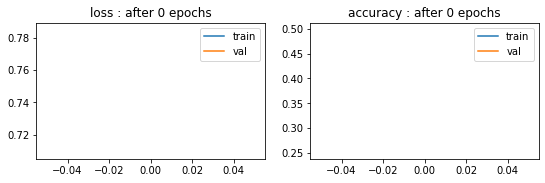

skipping saving...


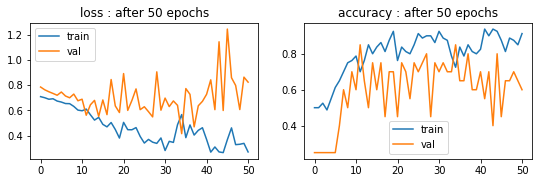

skipping saving...


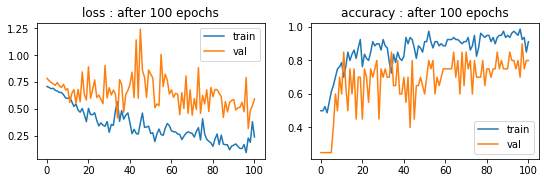

skipping saving...


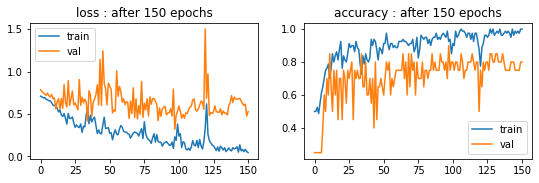

skipping saving...


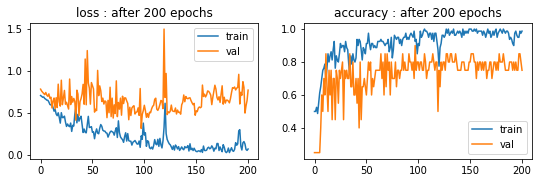

skipping saving...


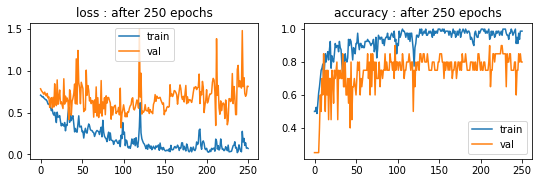

skipping saving...


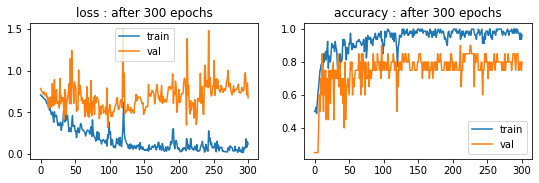

skipping saving...


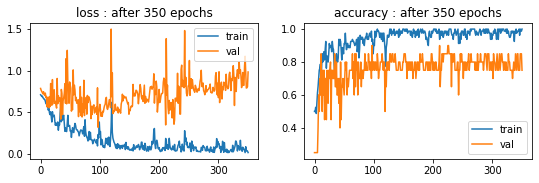

skipping saving...


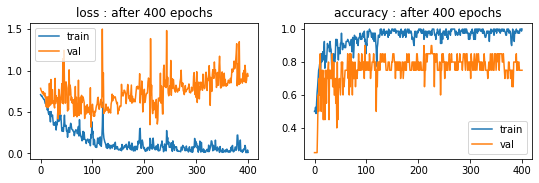

skipping saving...


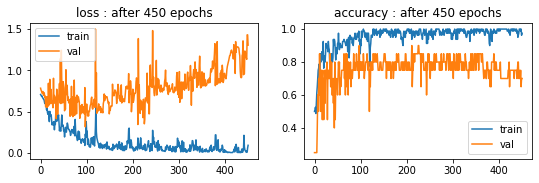

skipping saving...


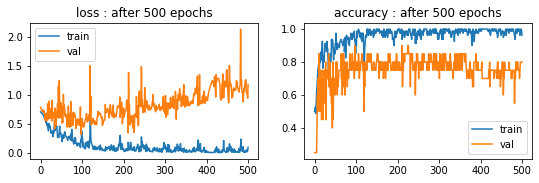

skipping saving...


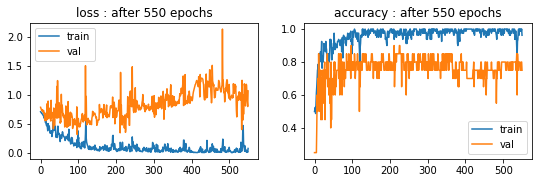

skipping saving...


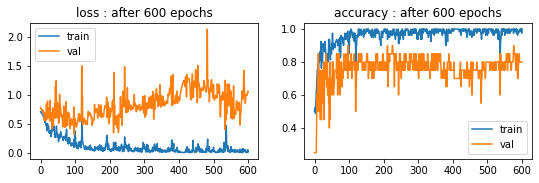

skipping saving...


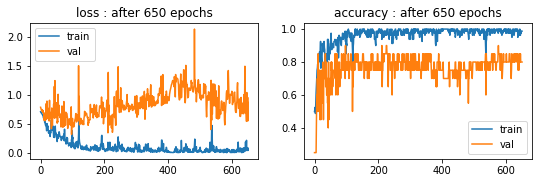

skipping saving...


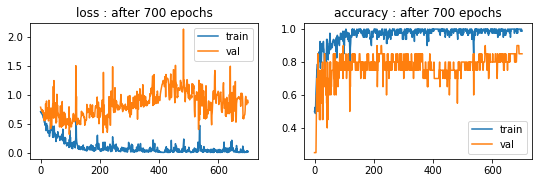

skipping saving...


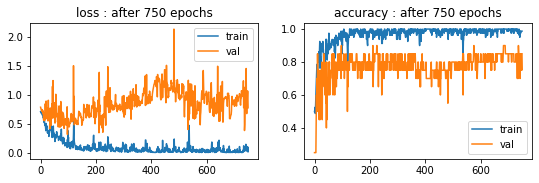

skipping saving...


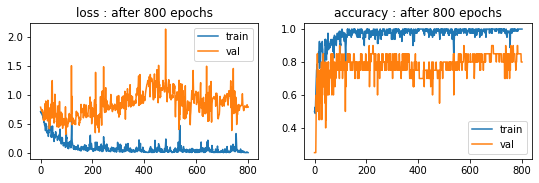

skipping saving...


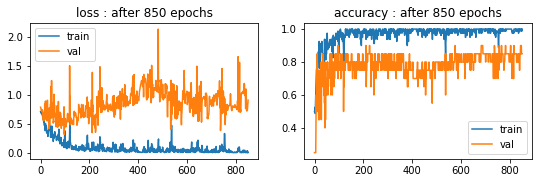

skipping saving...


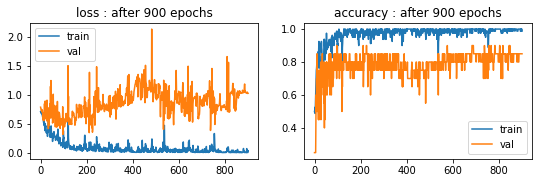

skipping saving...


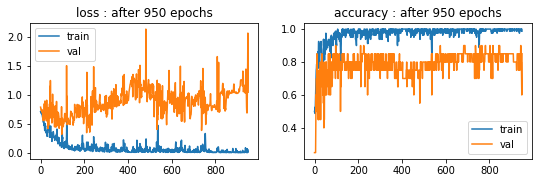

skipping saving...


In [82]:
train_loader= torch.utils.data.DataLoader(get_dataset(dataset_train_preprocessed, feature_len= feature_len), batch_size= 10, shuffle=True, drop_last= True)
val_loader=  torch.utils.data.DataLoader(get_dataset(dataset_test_preprocessed, feature_len= feature_len), batch_size= 10, shuffle=False, drop_last= True)

n_epochs= 1000
show_epoch= 50
save_epoch= 50

train(model, criterion, opt, train_loader, val_loader, n_epochs, device, show_epoch, save_epoch)